
**Forward propagation**

\begin{gather}
z_{1} = x\omega_{1}^{T} + b_{1}\\
a_{1} = \sigma_{1}(z_{1})\\
\\
z_{2} = a_{1}\omega_{2}^{T} + b_{2}\\
a_{2} = \sigma_{1}(z_{2})\\
\\
z_{3} = a_{2}\omega_{3}^{T} + b_{3}\\
a_{3} = \sigma_{2}(z_{3})\\
\end{gather}

**Backward propagation**

\begin{gather}
dz_{3} = dL * a_{3}(1 - a_{3})\\
dw_{3} = dz_{3}^{T}a_{2}\\
db_{3} = dz_{3}^{T}\textbf{1}\\
\\
dz_{2} = (dz_{3}w_{3})*dtanh\\
dw_{2} = dz_{2}^{T}a_{1}\\
db_{2} = dz_{2}^{T}\textbf{1}\\
\\
dz_{1} = (dz_{2}w_{2})*dtanh\\
dw_{1} = dz_{1}^{T}X\\
db_{1} = dz_{1}^{T}\textbf{1}\\
\end{gather}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os

In [2]:
def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [3]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

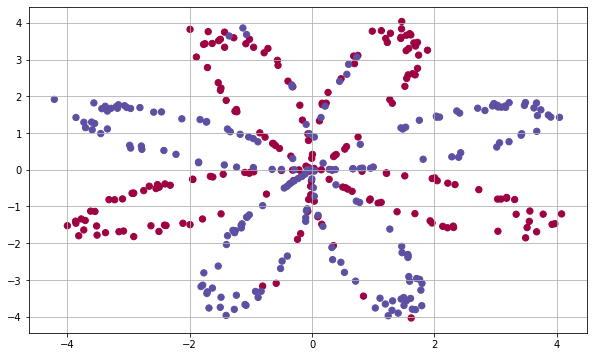

In [4]:
X, Y = load_planar_dataset() #загружаем датасет
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral);

In [14]:
class NN:
    def __init__(self, n_input, n_hidden, activation_funs):
        self.params = {
                            "w1": None,
                            "w2": None,
                            "w3": None,
                            "b1": None,
                            "b2": None,
                            "b3": None
        }

        self.velocities = {
                            "vw1": None,
                            "vw2": None,
                            "vw3": None,
                            "vb1": None,
                            "vb2": None,
                            "vb3": None
        }
        
        self.gradients = {
                            "dw1": None,
                            "dw2": None,
                            "dw3": None,
                            "db1": None,
                            "db2": None,
                            "db3": None,
                            "dz1": None,
                            "dz2": None,
                            "dz3": None
        }
        
        self.cache = {
                            "z1": None,
                            "a1": None,
                            "z2": None,
                            "a2": None,
                            "z3": None,
                            "a3": None,
                            "X": None
        }
        
        self._initialize_params(n_input, n_hidden)
        self._initialize_activations(activation_funs)
        
    
    def _initialize_params(self, n_input, n_hidden):
        
        self.params['w1'] = np.random.randn(n_hidden, n_input)
        self.params['w2'] = np.random.randn(n_hidden, n_hidden)
        self.params['w3'] = np.random.randn(1, n_hidden)
        self.params['b1'] = np.zeros((n_hidden,))
        self.params['b2'] = np.zeros((n_hidden,))
        self.params['b3'] = np.zeros((1,))
        
        for key in self.params.keys():
            self.gradients[key] = np.zeros_like(self.params[key])
        for key in self.params.keys():
            self.velocities[key] = np.zeros_like(self.params[key])
            
    
    def _initialize_activations(self, activation_funs):
        for i,activation in enumerate(activation_funs):
            if activation == "tanh":
                self.__dict__['activation'+str(i+1)] = np.tanh
                self.__dict__['activation'+str(i+1)+"_backward"] = \
                lambda x: 1 - np.tanh(x)**2
            if activation == "sigmoid":
                self.__dict__['activation'+str(i+1)] = self.sigmoid
                self.__dict__['activation'+str(i+1)+"_backward"] = \
                lambda x: self.sigmoid(x)*(1.-self.sigmoid(x))
        

    @staticmethod
    def sigmoid(z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)), 
            np.exp(z) / (1 + np.exp(z))
        )

    def collect_cache(self, **kwargs):
        for key in kwargs.keys():
            self.cache[key] = kwargs[key]
            
    def collect_grads(self, **kwargs):
        for key in kwargs.keys():
            self.gradients[key] = kwargs[key]
    
    def unpack_cache(self, keys):
        output = []
        for key in keys:
            output.append(self.cache[key])
        output = tuple(output)
        return output
    

    def forward(self, X):
        """Method for forward pass implementation
        
        Input:
            X - matrix of input data, shape (n, n_features)
        
        Output:
            computed logistic regression of X
        """
        
        z1 =X @ self.params['w1'].T + self.params['b1']
        a1 = self.activation1(z1)
        
        z2 = a1 @ self.params['w2'].T + self.params['b2']
        a2 = self.activation1(z2)

        z3 = a2 @ self.params['w3'].T + self.params['b3']
        a3 = self.activation2(z3)
        
        self.collect_cache(z1=z1, z2=z2, z3=z3, a1=a1, a2=a2, a3=a3, X=X)

        return a3
    
    def __call__(self, X):
        return self.forward(X)

    def backward(self, dL):
        
        z1, a1, z2, a2, z3, a3, X = self.unpack_cache(['z1', 'a1', 'z2', 
                                               'a2', 'z3', 'a3', 'X'])

        dz3 = dL * (a3*(1. - a3))
        dw3 = dz3.T @ a2
        db3 = dz3.T @ np.ones((z3.shape[0]))

        dz2 = (dz3 @ self.params['w3'])*self.activation1_backward(z2)
        dw2 = dz2.T @ a1
        db2 = dz2.T @ np.ones((z2.shape[0]))
        
        dz1 = (dz2 @ self.params['w2'])*self.activation1_backward(z1)
        dw1 = (dz1.T @ X)
        db1 = dz1.T @ np.ones(X.shape[0])

        self.collect_grads(dw3=dw3, dw2=dw2, dw1=dw1, db3=db3, db2=db2, db1=db1)

    
    def summary(self):
        num_layers = len(self.params)//2
        for i in range(1, num_layers + 1):
            w_ind, b_ind = f'w{i}', f'b{i}'
            print(f"Layer_{i}\t weights shape: {self.params[w_ind].shape}\t bias shape: {self.params[b_ind].shape}")

In [15]:
class Optimizer:
    def __init__(self, regression_class, lr=1e-2):
        self.model = regression_class
        self.lr = lr
        
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
        velocities = self.model.velocities
        #print("PARAMS:",params)
        #print("GRADS:",grads)
        for key in self.model.params.keys():
            mu = 0.95
            velocities[key] = mu*velocities[key] - self.lr*grads["d"+key]
            new_params[key] = params[key] + velocities[key]
        self.model.params = new_params
        
        
    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

In [7]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)

        
def binary_crossentropy(a, y, eps=1e-5):
    #print(len(a))
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))
    

In [16]:
X, y = load_planar_dataset(m=1000)

In [10]:
print(f"X shape is {X.shape},\ty shape is {y.shape}")

X shape is (1000, 2),	y shape is (1000, 1)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [24]:
model = NN(n_input=2, n_hidden=3, activation_funs=['tanh', 'sigmoid'])
optimizer = Optimizer(model, lr=1e-2)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)
model.summary()

Layer_1	 weights shape: (3, 2)	 bias shape: (3,)
Layer_2	 weights shape: (3, 3)	 bias shape: (3,)
Layer_3	 weights shape: (1, 3)	 bias shape: (1,)


In [25]:
num_epochs = 15000
loss_train = []
loss_test = []
for j in range(num_epochs):
    idx = [i for i in range(X_train.shape[0])]
    np.random.shuffle(idx)
    batch_idx = [idx[k] for k in range(128)]
    X_batch = []
    y_batch = []
    for i in batch_idx:
        X_batch.append(X_train[i])
        y_batch.append(y_train[i])
    X_batch = np.asarray(X_batch)
    y_batch = np.asarray(y_batch)
    a = model(X_batch)
    l = loss(a, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_train.append(l)
    a_val = model(X_test)
    loss_test.append(loss(a_val, y_test))
    
    if (j % 400 == 0):
        
        print("Epoch %d/%d\t Loss: %.3f"%(j, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_batch, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

Epoch 0/15000	 Loss: 0.744	Accuracy: 0.469	Val_loss: 0.726	Val_accuracy: 0.512
Epoch 400/15000	 Loss: 0.305	Accuracy: 0.867	Val_loss: 0.270	Val_accuracy: 0.892
Epoch 800/15000	 Loss: 0.153	Accuracy: 0.961	Val_loss: 0.250	Val_accuracy: 0.916
Epoch 1200/15000	 Loss: 0.205	Accuracy: 0.938	Val_loss: 0.246	Val_accuracy: 0.908
Epoch 1600/15000	 Loss: 0.169	Accuracy: 0.953	Val_loss: 0.240	Val_accuracy: 0.912
Epoch 2000/15000	 Loss: 0.301	Accuracy: 0.883	Val_loss: 0.246	Val_accuracy: 0.900
Epoch 2400/15000	 Loss: 0.261	Accuracy: 0.898	Val_loss: 0.234	Val_accuracy: 0.916
Epoch 2800/15000	 Loss: 0.280	Accuracy: 0.891	Val_loss: 0.232	Val_accuracy: 0.908
Epoch 3200/15000	 Loss: 0.195	Accuracy: 0.945	Val_loss: 0.227	Val_accuracy: 0.916
Epoch 3600/15000	 Loss: 0.225	Accuracy: 0.922	Val_loss: 0.223	Val_accuracy: 0.924
Epoch 4000/15000	 Loss: 0.165	Accuracy: 0.961	Val_loss: 0.215	Val_accuracy: 0.928
Epoch 4400/15000	 Loss: 0.299	Accuracy: 0.891	Val_loss: 0.211	Val_accuracy: 0.932
Epoch 4800/15000	 Los

Text(0, 0.5, 'Loss')

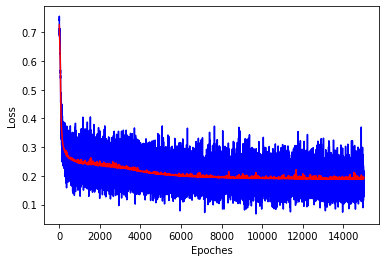

In [27]:
    plt.plot(loss_train, 'b')
    plt.plot(loss_test, 'r')
    plt.xlabel("Epoches")
    plt.ylabel("Loss")

Decision Boundary for train, hidden layer size 3


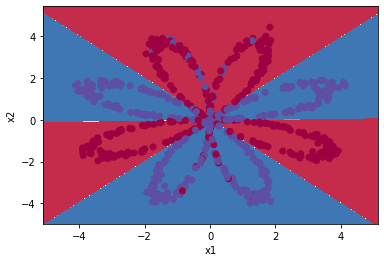

In [21]:
print("Decision Boundary for train, hidden layer size " + str(model.params['w1'].shape[0]))
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)
